## Score Function

Defined as gradient of log probability density function $$\nabla \log p(x)$$

Applications:
 - We can use this to "sample" from unknown density
 - Generally, we can think of starting from some random spot in data space (maybe uniformly sampled)
	 - Then follow derivatives to move towards higher likelihood position with Langevin Dynamics: $$x_{i+1} = x_i + \epsilon \nabla_x \log p(x) + \sqrt{2\epsilon}z_i$$
 - We can also use this for computing Fisher Divergence: $$D_F(p||q) = E_{p(x)}[||\nabla_x\log p(x) - \nabla_x\log q(x)||_2]$$


In this notebook I will:
1. Compute/estimate score function of gaussian and mixture gaussians
2.

In [38]:
import torch, numpy as np
import matplotlib.pyplot as plt
from functools import partial

import torch.nn as nn, torch.optim as optim
from torch import vmap
from torch.func import jacfwd
from tqdm.auto import tqdm

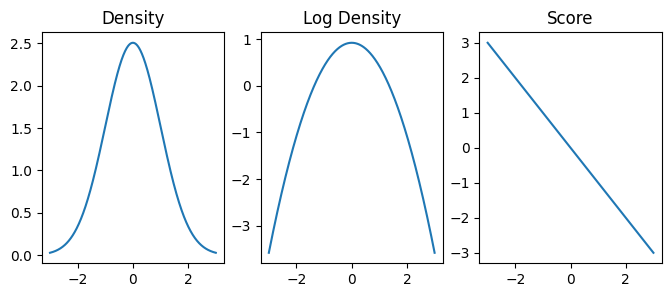

In [41]:
# Plot a gaussian and log normal
x = torch.linspace(-3, 3, 1000)

def norm_pdf(x, mu=0, sigma=1):
    return (1 / sigma * np.sqrt(2 * torch.pi)) * torch.exp( -0.5 * ((x - mu)/sigma)**2)

def norm_log_pdf(x, mu=0, sigma=1):
  return torch.log(norm_pdf(x, mu, sigma))

def gauss_score(x, mu=0, sigma=1):
  return jacfwd(norm_log_pdf)(x, mu, sigma)

density = norm_pdf(x)
log_density = norm_log_pdf(x)
score = vmap(gauss_score)(x)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8, 3))
ax1.plot(x, density)
ax1.set_title('Density')
ax2.plot(x, log_density)
ax2.set_title('Log Density')
ax3.plot(x, score)
ax3.set_title('Score');


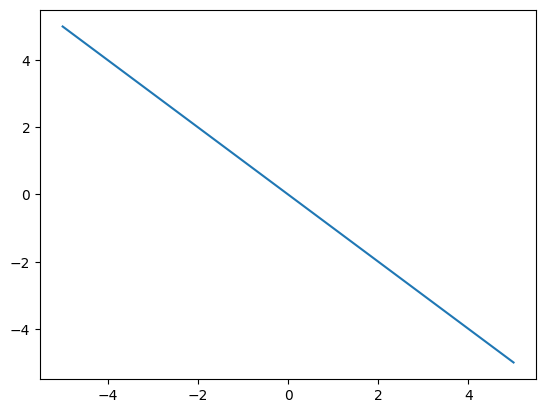

In [ ]:
ys = torch.log(norm_pdf(xs))
ys.backward(torch.ones_like(ys))
scores = xs.grad # Gradient of ys w.r.t. xs
plt.plot(xs.detach().numpy(), scores.detach().numpy());

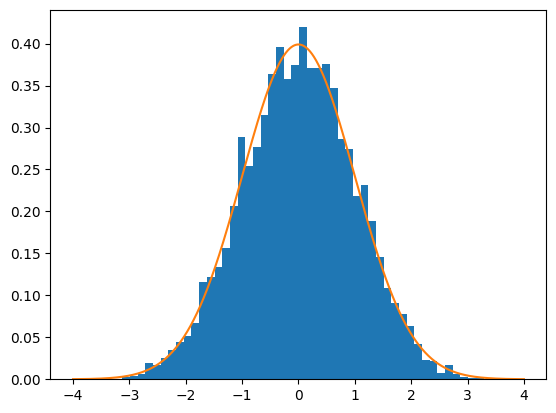

In [ ]:
# Approximating the score of a gaussian:

# First draw random samples, this is our "dataset"
samples = torch.normal(mean=0,std=1, size=(5000,1))

# Let's plot this
plt.hist(samples[:, 0], bins=50, density=True);

# Let's also overlay the actual pdf:
x=torch.linspace(-4, 4, 3000)
y=norm_pdf(x)

plt.plot(x.numpy(),y.numpy());

In [ ]:
# Ok so the dataset is pretty good, matches the distribution well.
# Now we want to use score matching loss and an MLP to approximate the score of standard normal distribution

from torch.func import jacfwd

def score_loss(model, x) -> float:
    '''
    Score loss = Expected [trace( d\dx(est_score) )  + 1/2 magnitude(est_score)^2]

    Params:
    x: input batch of data
    model: Our estimated score function

    Returns: Score matching loss (a float)
    '''
    # Compute jacobian of score fn (or hessian of logpdf) w.r.t. to each data point
    # gives shape (m, n, n) where m = number of datapoints in a batch, n is the data dimensionality
    jacs = torch.vmap(jacfwd(model))(x)

    # Get the trace of each jacobian
    tr = torch.vmap(torch.trace)(jacs)

    # We compute the second term and shape it to be like the first
    term2 = 0.5 * model(x)**2
    term2 = torch.reshape(term2, tr.shape)

    loss = torch.mean(tr + term2)
    return loss


model = torch.nn.Sequential(
    torch.nn.Linear(1, 4096),
    torch.nn.ReLU(),
    torch.nn.Linear(4096, 1)
)

actual_score = lambda x: -x

((actual_score(samples) - model(samples))**2).mean(), score_loss(model, samples)

(tensor(1.4017, grad_fn=<MeanBackward0>),
 tensor(0.2061, grad_fn=<MeanBackward0>))

In [ ]:
import torch.optim as optim

opt = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
model.train()

num_epochs=2000
for _ in range(num_epochs):
    opt.zero_grad()

    # loss
    loss = score_loss(model, samples)

    loss.backward()
    opt.step()

((actual_score(samples) - model(samples))**2).mean()


In [ ]:
# Now plot our learned score fn vs. actual score
x = torch.linspace(-5, 5, 3000)
y_act = actual_score(x)
y_pred = model(x.unsqueeze(1))

plt.plot(x, y_act)
plt.plot(x, y_pred.detach());